In [42]:
import pyvisa
import matplotlib.pyplot as plt
import numpy as np

In [43]:
rm = pyvisa.ResourceManager('@py')


In [71]:
class OSC:
    def __init__(self,address: str,rm: pyvisa.ResourceManager):
        self.address =  address
        self.rm = rm
        self.inst = None
        self.time = None #for retrieving waveform data
        self.voltage = None #for retrieving waveform data
        self.p2p1 = None #peak to peak measurement for channel 1
        self.p2p2 = None #peak to peak measurement for channel 2
        self.freq1 = None #freq measurement for channel 1
        self.freq2 = None #freq measurement for channel 2
        self.rise1 = None
        self.rise2 = None
        self.fall1 = None
        self.fall2 = None
        self.fs = None
        self.connect()  
        

    def connect(self):
        print("Connecting...")
        self.inst = rm.open_resource(self.address)
        self.inst.read_termination = '\n'
        print("Connected to...")
        print(self.inst.query('*IDN?'))

    def v_scale(self,scale,channel):
        self.inst.write('CH'+str(channel)+':VOLTS '+str(scale))
            
    def close(self):
        self.inst.close()

    def set_horizontal_scale(scale):
        self.inst.write('HOR:MAIN:SCALE '+ str(scale))

    def get_waveform_data(self,channel,plot = False):
        self.inst.write("DATA:SOURCE CH1")  #waveform source 
        self.inst.write("DATA:WIDTH 1")     #bytes per point
        self.inst.write("DATA:ENCdg RPBinary") #waveform format
        #value_in_YUNits = ((curve_in_dl - YOFF_in_dl) * YMUlt) + YZERO_in_YUNits    
        ymult = float(self.inst.query("WFMPRE:YMULT?")) #YMUlt
        yzero = float(self.inst.query("WFMPRE:YZERO?")) #YZERO
        yoff = float(self.inst.query("WFMPRE:YOFF?")) #YOFF
        xincr = float(self.inst.query("WFMPRE:XINCR?")) #interval between points - specified by WFMPre:XUNit(?) (seconds) 
        self.fs = 1/xincr
        self.inst.write("CURVE?")
        raw_data = self.inst.read_raw()
        header_length = int(raw_data[1:2])  # Correctly extract header length
        num_bytes = int(raw_data[2:2 + header_length])  # Extract number of data bytes
        data_start = 2 + header_length  # Find the actual data start index
        data = np.frombuffer(raw_data[data_start:data_start + num_bytes], dtype=np.uint8)
        self.voltage = (data - yoff) * ymult + yzero
        self.time = np.arange(len(self.voltage)) * xincr 
        if plot == True:
            plt.figure(figsize=(10, 4))
            plt.plot(self.time, self.voltage)
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.title("Oscilloscope Waveform")
            plt.grid()
            plt.show()

    def get_p2p(self,channel):
        self.inst.write("MEASUrement:IMMed:TYPe PK2PK")
        self.inst.write("MEASUrement:IMMed:SOURCE CH"+str(channel))
        if channel == 1:
            self.p2p1 = float(self.inst.query("MEASUrement:IMMed:VAL?"))
        elif channel == 2:
            self.p2p2 = float(self.inst.query("MEASUrement:IMMed:VAL?"))

    def get_freq(self,channel):
        self.inst.write("MEASUrement:IMMed:TYPe FREQ")
        self.inst.write("MEASUrement:IMMed:SOURCE CH" + str(channel))
        x = float(self.inst.query("MEASUrement:IMMed:VAL?"))
        setattr(self, f"freq{channel}", x)
        
    def get_rise_time(self,channel):
        self.inst.write("MEASUrement:IMMed:TYPe RISe")
        self.inst.write("MEASUrement:IMMed:SOURCE CH" + str(channel))
        x = float(self.inst.query("MEASUrement:IMMed:VAL?"))
        setattr(self, f"rise{channel}", x)

    def get_fall_time(self,channel):
        self.inst.write("MEASUrement:IMMed:TYPe FALL")
        self.inst.write("MEASUrement:IMMed:SOURCE CH" + str(channel))
        x = float(self.inst.query("MEASUrement:IMMed:VAL?"))
        setattr(self, f"fall{channel}", x)

In [72]:
osc = OSC('USB0::1689::931::C043627::0::INSTR',rm)


Connecting...
Connected to...
TEKTRONIX,TDS 2012C,C043627,CF:91.1CT FV:v24.26


In [38]:
osc.v_scale(0.2,1)

In [ ]:
osc.get_waveform_data(1,True)
osc.fs

In [52]:
osc.get_p2p(1)
osc.p2p1

0.5840001106

In [60]:
osc.get_freq(1)
osc.freq1

200.0

In [68]:
osc.get_rise_time(1)
osc.rise1*1e6

66.85709999999999

In [69]:
osc.get_fall_time(1)
osc.fall1*1e6

102.0

In [ ]:
osc.close()

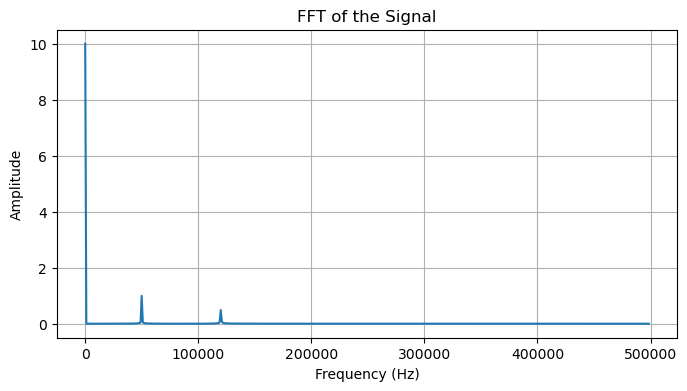

In [10]:
osc.write("MEASUrement:IMMed:TYPe FREQ")
osc.write("MEASUrement:IMMed:SOURCE CH1")
osc.query("MEASUrement:IMMed:VAL?")

'8.59746704102E1'

In [ ]:
osc.write("MEASUrement:IMMed:TYPe FREQ")
osc.write("MEASUrement:IMMed:SOURCE CH1")
osc.query("MEASUrement:IMMed:VAL?")